---
title: "A Minimal Transformer"
date: 2025-09-18
categories: [nlp, translation, pytorch]
description: "Under 100 lines. English to Spanish with PyTorch’s nn.Transformer and OPUS Books."
page-layout: article
title-block-banner: false
execute:
  echo: true
  warning: false
  cache: true
  freeze: auto
---

Self-attention is one of the core building blocks of modern deep learning. The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper by Vaswani et al. (2017) introduced the now-standard *scaled dot-product self-attention* and the Transformer architecture that builds on it.

In this post, we’ll recreate a simple version of that Transformer and train it on a small English-Spanish dataset. The goal is not to build everything from scratch, but also not to hide all the details. We are trying to strike a balance between using the nuts and bolts of Transformers and PyTorch's abstractions, while keeping it pedagogical and practically useful. The entirety of the core code stays under 100 lines and you should be able to run it on a basic T4 GPU on a service like Google Colab.

I’ll walk you through data loading, building the architecture, training, and decoding.

## Install & Imports

We’ll install a few libraries and set things up. Also setting seeds and picking the device (GPU if available).

In [2]:
#| message: false
#| warning: false

!pip install -U datasets huggingface_hub fsspec --quiet

import warnings
warnings.filterwarnings('ignore')

import torch, math, random
import torch.nn as nn
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

random.seed(42)
torch.manual_seed(42)

## Configuration & Tokenizer

Next, we’ll set a few model hyperparameters. These are deliberately chosen to keep the architecture lightweight. Feel free to tweak them if you are interested and have more compute available.

- `MODEL_DIM`: the size of the hidden representations (256)
- `NHEAD`: number of attention heads (4)
- `NLAYER`: number of Transformer layers (2)
- `MAX_LEN`: hard cap on tokenised sequence length (64)

For tokenization, we’ll use the pretrained MarianMT tokenizer (`opus-mt-en-es`). We grab the `BOS` (beginning of sentence), `EOS` (end of sentence), and `PAD` (padding) token IDs. In this tokenizer, `pad_token_id == bos_token_id`, but that's fine for our minimal example.

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIM, MAX_LEN, NHEAD, NLAYER = 256, 64, 4, 2

# MarianMT uses PAD for BOS
tok = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
BOS, EOS, PAD = tok.pad_token_id, tok.eos_token_id, tok.pad_token_id

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

## Encoding & Batching Helpers

- `encode(pair)` takes one example (with keys `[`"translation"`][`"en"`]` and `[`"translation"`][`"es"`]`)  
  and returns two tensors: `[BOS] + src_ids + [EOS]` and `[BOS] + tgt_ids + [EOS]`.  
- `collate(batch)` pads all sequences in a batch to the same length (using `pad_sequence`).

In [5]:
# Encoding and batching
def encode(pair):
  src = tok(pair["translation"]["en"], truncation=True, max_length=MAX_LEN)["input_ids"]
  tgt = tok(pair["translation"]["es"], truncation=True, max_length=MAX_LEN)["input_ids"]
  return torch.tensor([BOS]+src+[EOS]), torch.tensor([BOS]+tgt+[EOS])

def collate(batch):
  src, tgt = zip(*[encode(x) for x in batch])
  return pad_sequence(src, batch_first=True, padding_value=PAD), pad_sequence(tgt, batch_first=True, padding_value=PAD)

## Dataset and DataLoader

We use a small slice of the data to keep experiments quick: 5% of the OPUS Books English to Spanish split. Each batch contains 128 examples, and we enable shuffling so the model sees the data in a different order each epoch. The DataLoader handles batching, padding, and device transfer for us, which keeps the training loop clean and fast.

In [6]:
# Dataset and loader (5% for better coverage)
data = load_dataset("opus_books", "en-es", split="train[:5%]")
loader = DataLoader(data, batch_size=128, collate_fn=collate, shuffle=True)

README.md: 0.00B [00:00, ?B/s]

en-es/train-00000-of-00001.parquet:   0%|          | 0.00/16.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/93470 [00:00<?, ? examples/s]

# Sinusoidal Positional Encoding

Transformers process tokens in parallel, so they need some way to capture token order. The original Transformer paper uses *sinusoidal* positional encoding, based on fixed sine and cosine functions. You don’t need to memorize this formula or its corresponding code. The key idea is that each position gets a unique, smooth encoding based on its index.

- `pos`: token position in the sequence (0, 1, 2, …)
- `i`: dimension index (0 to `d_model - 1`)
- `d_model`: embedding size

$$
\text{PE}_{(pos, 2i)} = \sin\left( \frac{pos}{10000^{\frac{2i}{d_{model}}}} \right)
$$

$$
\text{PE}_{(pos, 2i+1)} = \cos\left( \frac{pos}{10000^{\frac{2i}{d_{model}}}} \right)
$$

You might wonder why two functions are used for even and odd positions in the embeddings. The idea is that two functions provide a richer signal, so the model can better tell positions apart.

In [ ]:
class PosEnc(nn.Module):
  """
  Based on the implementation by:
  https://nlp.seas.harvard.edu/2018/04/03/attention.html
  """
  def __init__(self, d, L=5000):
    super().__init__()
    pe = torch.zeros(L, d)
    pos = torch.arange(0, L).unsqueeze(1)
    div = torch.exp(torch.arange(0, d, 2) * -math.log(10000.0) / d)
    pe[:, 0::2], pe[:, 1::2] = torch.sin(pos*div), torch.cos(pos*div)
    self.register_buffer("pe", pe.unsqueeze(0))  # registered buffer
  def forward(self, x): return x + self.pe[:, :x.size(1)].to(x.device)

## Transformer Model

We’re now ready to define the model architecture, using a simple PyTorch `nn.Module`. Our Transformer has an embedding layer with padding support, adds positional encodings, and uses PyTorch’s built-in `nn.Transformer` with `norm_first=False` to match the original post-LayerNorm design.

In the forward pass, we prepare three masks:

1. `smask`: masks out padding tokens in the source.
2. `tmask`: masks out padding tokens in the target.
3. `seq_mask`: a causal mask for the decoder, built with `generate_square_subsequent_mask`, which prevents each token from attending to future tokens.



In [ ]:
class Transformer(nn.Module):
  def __init__(self, vocab):
    super().__init__()
    self.emb = nn.Embedding(vocab, MODEL_DIM, padding_idx=PAD)
    self.pe = PosEnc(MODEL_DIM)
    self.tr = nn.Transformer(
      MODEL_DIM, NHEAD,
      num_encoder_layers=NLAYER,
      num_decoder_layers=NLAYER,
      dim_feedforward=2048,
      dropout=0.1,
      batch_first=True,
      norm_first=False  # Post-LN as in the original Transformer paper
    )
    self.gen = nn.Linear(MODEL_DIM, vocab)
  def forward(self, src, tgt):
    smask, tmask = src == PAD, tgt == PAD
    seq_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(src.device)
    src, tgt = self.pe(self.emb(src)), self.pe(self.emb(tgt))
    return self.gen(self.tr(src, tgt, tgt_mask=seq_mask, src_key_padding_mask=smask, tgt_key_padding_mask=tmask))

With the Transformer architecture defined, it’s time to connect the training components—optimizer, scheduler, and loss—so we can actually train the model on data.

## Setup: Model, Optimizer, Scheduler, Loss

We instantiate the Transformer, configure the AdamW optimiser, and set up a scheduler that warms up for 4,000 steps then reduces the learning rate in proportion to the inverse square root of the step count. We then apply a cross-entropy loss that ignores padding tokens.

```python
model = Transformer(tok.vocab_size).to(DEVICE)

# 2. Optimizer: AdamW with Vaswani hyperparams
opt = torch.optim.AdamW(
    model.parameters(),
    lr=1.0,               # peak learning rate
    betas=(0.9, 0.98),
    eps=1e-9
)

# 3. Scheduler: warm up for 4,000 steps, then 1/√step decay
sched = torch.optim.lr_scheduler.LambdaLR(
    opt,
    lambda step: min((step + 1) ** -0.5,
                     (step + 1) * 4000 ** -1.5)
)

# 4. Loss: ignore PAD tokens so they don’t count toward loss
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)


In [ ]:
model = Transformer(tok.vocab_size).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=1.0, betas=(0.9, 0.98), eps=1e-9)
sched = torch.optim.lr_scheduler.LambdaLR(opt, lambda s: min((s+1)**-0.5, (s+1)*4000**-1.5))
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)

## 8. Training loop (20 epochs)

For each epoch, we loop over the batches. We start by moving the source and target sequences to the device. The model takes the source together with the target sequence shifted by one token, so it learns to predict the next token at each step.

We calculate cross-entropy loss against the shifted target, ignoring padding tokens. Then we clear the old gradients, run backpropagation, update the model with the optimiser, and adjust the learning rate with the scheduler. At the end of each epoch, we average the batch losses and print the result to see how training is going.


In [ ]:
for epoch in range(20):
  model.train()
  total_loss, n = 0, 0
  for src, tgt in loader:
    src, tgt = src.to(DEVICE), tgt.to(DEVICE)
    out = model(src, tgt[:, :-1])
    loss = loss_fn(out.reshape(-1, out.size(-1)), tgt[:, 1:].reshape(-1))
    opt.zero_grad(); loss.backward(); opt.step(); sched.step()
    total_loss += loss.item(); n += 1
  print(f"Epoch {epoch+1} Loss: {total_loss / n:.3f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1 Loss: 10.441
Epoch 2 Loss: 8.017
Epoch 3 Loss: 5.730
Epoch 4 Loss: 4.864
Epoch 5 Loss: 4.200
Epoch 6 Loss: 3.721
Epoch 7 Loss: 3.403
Epoch 8 Loss: 3.161
Epoch 9 Loss: 2.946
Epoch 10 Loss: 2.755
Epoch 11 Loss: 2.564
Epoch 12 Loss: 2.387
Epoch 13 Loss: 2.221
Epoch 14 Loss: 2.053
Epoch 15 Loss: 1.909
Epoch 16 Loss: 1.779
Epoch 17 Loss: 1.662
Epoch 18 Loss: 1.554
Epoch 19 Loss: 1.469
Epoch 20 Loss: 1.396


## 9 Greedy Translation and a quick test

At inference time we switch the model to evaluation mode and disable gradients. We tokenise the input string, wrap it with begin-of-sequence and end-of-sequence markers, and move everything to the selected device. The target starts as just the begin-of-sequence token.

We then decode greedily for up to 15 steps: at each step we run `model(src, tgt)`, take the most probable next token, append it to `tgt`, and stop early if we generate the end-of-sequence token. Finally we decode the tokens between the markers, skipping special tokens, to produce a clean string.

The short test at the end prints an English prompt and the model’s Spanish translation.

In [ ]:
@torch.no_grad()
def translate(txt):
  model.eval()
  src = tok(txt, return_tensors="pt")["input_ids"][0]
  src = torch.tensor([[BOS] + src.tolist() + [EOS]]).to(DEVICE)
  tgt = torch.tensor([[BOS]]).to(DEVICE)
  for _ in range(15):
    out = model(src, tgt)
    next = out[0, -1].argmax().item()
    tgt = torch.cat([tgt, torch.tensor([[next]]).to(DEVICE)], dim=1)
    if next == EOS: break
  return tok.decode(tgt[0, 1:-1], skip_special_tokens=True)

# Test
print("\nTranslation:")
print("EN: Hello, how are you?")
print("ES:", translate("Hello, how are you?"))


Translation:
EN: Hello, how are you?
ES: ¿Cómo está todo?


## 10. Visualising positional encoding

To finish, we plot the first 50 dimensions of the positional encoding at position 1. The alternating sine and cosine waves are easy to see, and they illustrate how the model introduces positional information into the token embeddings.

I hope this walkthrough has helped clarify some of the details, and that the code is useful as a minimal yet faithful reimplementation of *Attention Is All You Need*, complete with a real translation example.


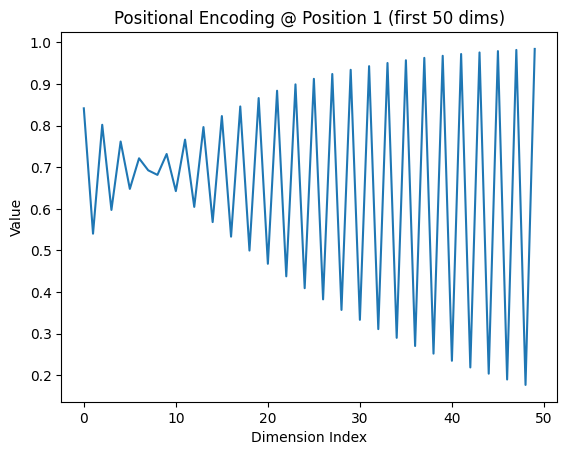

In [ ]:
import matplotlib.pyplot as plt

pos_enc = PosEnc(MODEL_DIM)
example = pos_enc.pe[0, 1, :50].cpu()
plt.plot(example)
plt.title("Positional Encoding @ Position 1 (first 50 dims)")
plt.xlabel("Dimension Index")
plt.ylabel("Value")
plt.show()